# Purpose

Create a colormap that has a constant color but varying alpha channel. Use [matplotlib.colors.ListedColormap](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.colors.ListedColormap.html#matplotlib.colors.ListedColormap). See [Creating listed colormaps](https://matplotlib.org/3.2.1/tutorials/colors/colormap-manipulation.html#creating-listed-colormaps) at [Creating Colormaps in Matplotlib](https://matplotlib.org/3.2.1/tutorials/colors/colormap-manipulation.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle

%matplotlib inline

# Define some colors

In [2]:
purple = (128/255, 0, 128/255)
ca = (73/255, 60/255, 255/255)  #493cff
cb = (171/255, 60/255, 255/255)  #ab3cff

# Try things

## Add alpha channel to a color

In [5]:
np.array([*purple, 1.])

array([0.50196078, 0.        , 0.50196078, 1.        ])

## Create array with same 4 channel color for each row

In [6]:
temp = np.ones((6,4))
temp

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [7]:
temp * np.array([*purple, 1.])

array([[0.50196078, 0.        , 0.50196078, 1.        ],
       [0.50196078, 0.        , 0.50196078, 1.        ],
       [0.50196078, 0.        , 0.50196078, 1.        ],
       [0.50196078, 0.        , 0.50196078, 1.        ],
       [0.50196078, 0.        , 0.50196078, 1.        ],
       [0.50196078, 0.        , 0.50196078, 1.        ]])

# Make ListedColormap with varying alpha channel

## Forward and reverse colormaps

In [3]:
# 4-channel array of 1's
N = 256
vals_linear_alpha = np.ones((N, 4))

# Fill 4th channel (alpha channel) with linearly varying values
vals_linear_alpha[:, 3] = np.linspace(0, 1, N)

# Create array of 1 color with linearly varying alpha values
temp = vals_linear_alpha * np.array([*purple, 1.])

# Turn array into forward and reverse colormaps
cmap_purple_linear_alpha = ListedColormap(temp)
cmap_purple_linear_alpha_reversed = cmap_purple_linear_alpha.reversed()


### Check colormap values

In [4]:
cmap_purple_linear_alpha_reversed(0)

(0.5019607843137255, 0.0, 0.5019607843137255, 1.0)

In [5]:
cmap_purple_linear_alpha_reversed(255)

(0.5019607843137255, 0.0, 0.5019607843137255, 0.0)

### Try plotting colormap

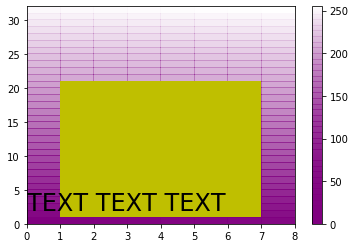

In [62]:
data = np.linspace(0, 255, N)
data = np.reshape(data, (32, 8))

rect = Rectangle((1, 1), 6, 20, linewidth=3, edgecolor='none', facecolor='y')

fig, ax = plt.subplots()
ax.add_patch(rect)
ax.text(0, 2, "TEXT TEXT TEXT", fontsize=24)
psm = ax.pcolormesh(data, cmap=cmap_purple_linear_alpha_reversed, rasterized=True, vmin=0, vmax=255)
fig.colorbar(psm, ax=ax)

Note the z ordering of items in the plot.

### Change z order

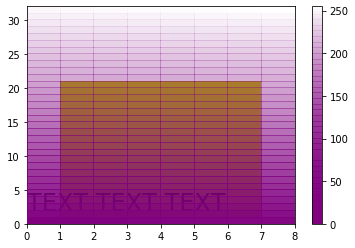

In [65]:
rect2 = Rectangle((1, 1), 6, 20, linewidth=3, edgecolor='none', facecolor='y')

fig, ax = plt.subplots()
ax.add_patch(rect2)
ax.text(0, 2, "TEXT TEXT TEXT", fontsize=24, zorder=10)
psm = ax.pcolormesh(data, cmap=cmap_purple_linear_alpha_reversed, rasterized=True, vmin=0, vmax=255, zorder=20)
fig.colorbar(psm, ax=ax)

# Use imshow as substitute for Rectangle with an alpha gradient

See [Bar chart with gradients](https://matplotlib.org/3.2.0/gallery/lines_bars_and_markers/gradient_bar.html), which says:

>Matplotlib does not natively support gradients. However, we can emulate a gradient-filled rectangle by an AxesImage of the right size and coloring.

It is critical to understand [origin and extent in imshow](https://matplotlib.org/tutorials/intermediate/imshow_extent.html).

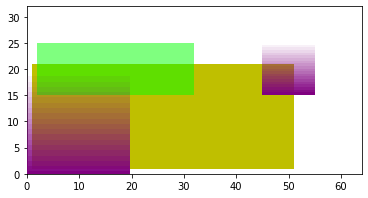

In [78]:
rect1 = Rectangle((1, 1), 50, 20, linewidth=3, edgecolor='none', facecolor='y')
rect2 = Rectangle((2, 15), 30, 10, linewidth=3, edgecolor='none', facecolor=(0., 1., 0., 0.5))

# Create image data
data = np.ones((20, 20, 4))
# Fill each row with color having linearly decreasing alpha value
data_copy = data.copy()
for i, row in enumerate(data_copy):
    data[i, :] *= cmap_purple_linear_alpha_reversed(int(i * 255/19))
    # print(i, data[i, :])

fig, ax = plt.subplots()
ax.set_xlim(0, 64)
ax.set_ylim(0, 32)

# Order of adding patches determines zorder
ax.add_patch(rect1)
ax.add_patch(rect2)

# Add actual size image but make sure it is in front of Rectangles
img1 = ax.imshow(data, zorder=20)

# Scale image size and set its position using
# extent=(left, right, lower, upper) which is the same as
# extent=(left, left+width, lower, lower+height)
img2 = ax.imshow(data, zorder=30, extent=(30, 40, 10, 20), origin='lower')
# Note that the image can be moved after the fact:
extent = img2.get_extent()
delta_x = 15
delta_y = 5
new_extent = (extent[0] + delta_x,
              extent[1] + delta_x,
              extent[2] + delta_y,
              extent[3] + delta_y,
             )
img2.set_extent(new_extent)


# Make GradientRectangle class

## Code

In [46]:
class GradientRectangle:
    
    def __init__(self, position, width, height, cmap, ax, npix_x=20, npix_y=50, zorder=100):
        self._check_position(position)
        self.position = position
        self.width = width
        self.height = height
        self.cmap = cmap
        self.ax = ax
        self._data = self._make_image(npix_x, npix_y)
        if ax:
            self.img = ax.imshow(self._data, 
                                 extent=self._to_extent(), 
                                 origin='lower',
                                 zorder=zorder
                                )
        
    def _make_image(self, npix_x, npix_y):
        temp = np.ones((npix_y, npix_x, 4))
        print(temp.shape)
        temp_copy = temp.copy()
        for i, _ in enumerate(temp_copy):
            temp[i, :] *= self.cmap(int(i * 255/temp.shape[0]))
        return temp
    
    def _check_position(self, position):
        assert isinstance(position, (list, tuple))
        assert len(position) == 2
        
    
    def _to_extent(self):
        return (self.position[0],
                self.position[0] + self.width,
                self.position[1],
                self.position[1] + self.height
               )
    
    def _to_position_width_height(extent):
        self.position[0] = extent[0]
        self.position[1] = extent[2]
        # self.width = extent[0] + extent[1]
        # self.height = extent[2] + extent[3]
    
    def get_xy(self):
        return self.position
    
    def set_xy(self, new_position):
        self._check_position(new_position)
        self.position = new_position
        if ax:
            self.img.set_extent(self._to_extent())
        
        
gr = GradientRectangle(position=(0, 0), width=10, height=30, cmap=cmap_purple_linear_alpha_reversed, ax=None)

(50, 20, 4)


## Try it out

(20, 20, 4)


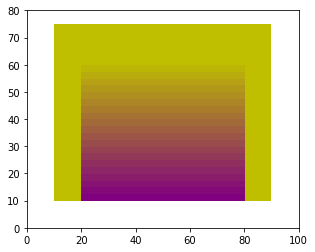

In [47]:
rect1 = Rectangle((10, 10), 80, 65, linewidth=3, edgecolor='none', facecolor='y')

fig, ax = plt.subplots()
ax.set_xlim(0,100)
ax.set_ylim(0,80)
ax.set_aspect('equal')
ax.add_patch(rect1)

gr = GradientRectangle(position=(20, 10), 
                       width=60, 
                       height=50, #45*2.5, 
                       cmap=cmap_purple_linear_alpha_reversed, 
                       ax=ax,
                       npix_y=20,
                       zorder=20
                      )



In [30]:
print(gr.position)
print(gr.width, gr.height)
print(gr._to_extent())

(20, 30)
60 112.5
(20, 80, 30, 142.5)


In [31]:
gr.img.get_extent()

(20, 80, 30, 142.5)

In [26]:
90/2.5

36.0